# <b>機械学習の基礎-3</b>
アンサンブルや特徴量エンジニアリングについてメモしておく。  

参考：  
https://datawokagaku.com/ensemble/

## アンサンブル
複数の機械学習モデルを組み合わせて予測する手法。  
一般的に単一のモデルよりも精度が高く、実務での予測はアンサンブルが主流。  
アンサンブルは主にバギング、ブースティング、スタッキングの3種類がある。

組み合わせるモデルはそれぞれの相関が低い（似ていない）モデルが望ましく、できるだけ多種多様なモデルを用いる。  
※弱学習器を使うのが良いようだが、KaggleではGBDTとニューラルネットの組み合わせを行っている例もあるので、  
　必ずというわけではなさそう。

## バギング(bagging: bootstrap aggregating)
下記の流れで予測するのがバギング。
1. 学習データを母集団として、重複を許してランダムに標本抽出する。    
    （重複を許して： 同じレコードが何回出てきてもよい。）
2. 抽出した学習データでモデルに学習させる。
3. 学習させたいモデルの数だけ1.～2.を繰り返す（並列にモデルを複数個作るイメージ）。
4. 全学習済みモデルの予測結果の多数決や確率の平均をとり、それをバギングによる予測結果とする。  

学習データの一部しか使わずに学習させるため、high bias low variance気味になるので、  
モデルには高varianceになりやすい決定木を用いることが多い。

## ランダムフォレスト(Random Forest)
バギングにおいて学習モデルに決定木を採用し、さらに特徴量を選択して学習させるアンサンブル手法。  
それぞれの学習モデルで一部の学習データと特徴量を使わないことで、少し異なる決定木を複数作る。  
（相関が低いモデルを作ることが狙い。アンサンブルでは多種多様なモデルを用いることが望ましいため。）

## ブースティング(boosting)
バギングと異なり、直列に弱学習器を順次作っていき、  
それらの予測値ごとに重みをつけて足し合わせたものを最終的な予測値とする手法。  
下記の流れのように、「残差を目的変数として学習し、その予測値で残差を埋める」というプロセスを繰り返して、  
それぞれのモデルでの残差の予測値に学習率を掛けて足し合わせた結果を最終的な予測値とする。  

<b>◎勾配ブースティング決定木（回帰）の例</b>  
弱学習器（決定木）をN個作成する（N回のイテレーションを実施する）場合を考える。  
t回目のイテレーションにおけるブースティング全体の予測値を$\hat{F_t}(x)$、  
このとき作成した決定木の予測結果を$\hat{f_t}(x)$、  
これの残差を$r_t$（$i$番目のデータの残差は$r_{ti}$）とおく。  
また、最初のイテレーションでは$\hat{F_0}(x)=\bar{y}$とする。  
このとき、予測値が常に0なので残差は目的変数に等しい（$r_{0i}=y_i$）。

ブースティングでは以下の手順をN回繰り返す。(t = 1,2,...,N)

1. 残差をt-1回目までの予測値で埋める。※t=1のときは初期値$\hat{F_0}(x)$から計算。  
   $r_{t} = y - \eta\hat{F_{t-1}}$

2. 弱学習器$\hat{f_t}$を学習データ$(X,r_{t})$で学習
3. ひとつ前のイテレーション結果に予測値を足したものをt回目での予測結果とする。  
   $\eta$は過学習を防ぐための学習率。(学習をshrinkageさせる役割)  
   $\hat{F_t}(x) = \hat{F_{t-1}}(x) + \eta\hat{f_{t}}(x)$
   
したがって、最終的な予測値（N回目の予測値）は下記のようになる。
$$\hat{F_N}(x) = \hat{f_0}(x) + \sum_{t=1}^N \eta\hat{f_t}(x)$$

実は1.の残差は最小二乗法における損失の勾配を表す。  
勾配ブースティングではこの勾配が小さくなるように学習している。  

<b>◎勾配ブースティング決定木（2値分類）の例</b>  
回帰の場合と初期値や予測値の使い方が異なる。  
分類では最初のイテレーションの予測値は$\hat{F_0}(x)=\log(\frac {\bar{y}}{1-\bar{y}})$とする。  
これは陽性確率pを目的変数$y$の平均値とした場合の対数オッズ比である。  
(損失関数LogLossを対数オッズ比で偏微分したときに目的変数$y$の平均値で最小になるため。)  
この初期値を踏まえ、勾配ブースティング決定木による分類の流れは下記。  

以下の手順をN回繰り返す。(t = 1,2,...,N)  

1. 残差をt-1回目までの予測値で埋める。  
   右辺の2項目はt-1回目までの予測値をシグモイド関数に入れて確率(以降$p$で表わす)の形にし、  
   これを目的変数y(0 or 1)から引いたものを残差としている。
   $$r_{t} = y - \frac {1}{1+e^{-(F(t-1))}}$$  

2. 弱学習器$\hat{f_t}$を学習データ$(X,r_{t})$で学習。ここでの弱学習器には"回帰"の決定木を使うことに注意。  
   学習し、葉の値が算出されるが、これをそのまま予測値としては使わず下記の値$f_t$で葉の値を置き換え、  
   これを予測値とする。    
   $$f_t(x_i) = \frac {\sum_{x_i\in{R}} (y_i-p)} {\sum_{x_i\in{R}} p(1-p)}$$  
   ※ $p = \frac {1}{1+e^{-(F(t-1))}}$  
   $x_i\in{R}$はあるリージョン(=葉)$R$に落ちてくる学習データを表し、分子はそれらの残差の和、  
   分母はt-1回目に予測値として出力された陽性率pと陰性率を乗じた値の和となっている。  
   (この導出も損失関数から可能だが割愛。)  

3. 回帰と同様、ひとつ前のイテレーション結果に予測値を足したものをt回目での予測結果とする。  
   $\eta$は過学習を防ぐための学習率。(学習をshrinkageさせる役割)  
   $\hat{F_t}(x) = \hat{F_{t-1}}(x) + \eta\hat{f_{t}}(x)$  
   確率の形で予測値を出力する場合は、$\hat{F_t}(x)$をシグモイド関数にいれる。  

<br></br>
うまくいけばbiasとvarianceの両方を下げることができ、バギングよりも精度が高くなることが期待できる。  
弱学習器には決定木を採用することが多い。  
2023年3月時点で、このブースティングをベースとした勾配ブースティング決定木(GBDT)とニューラルネットが機械学習の主流。  
(画像認識、自然言語処理等ではニューラルネット、テーブルデータではGBDTの方が使われるぽい。)  


## AdaBoost(Adaptive Boosting)
基本的なブースティングのアルゴリズムの一つ。  
損失が大きい（上手く予測できなかった）データに重みをつけて次の学習で重点的に学習できるようにする手法。  
データに重みをつけるというのは、通常は各データの損失を表す関数ごとに重み$\omega_i$をつけるということ。  
これを全データ分足し合わせたものが弱学習器の損失関数になり、これが最小になるように学習する。  
$$L(x,y)=\frac{1}{m}\sum_{i=1}^m l(x_i,y_i)$$ 
この$l(x_i,y_i)$に対して損失の大きさに応じた重み$\omega_i$がつけられる。  
最初のイテレーションでは一律$\omega_i=\frac{1}{m}$がかけられ、  
次のイテレーションから各データの損失の大きさに応じて$\omega_i$は更新されていく。  
また、弱学習器自体の重み$\alpha$も損失に応じて計算され、  
AdaBoostでの最終的な予測値はこの重みと各弱学習器の予測結果を掛け合わせた合計となる。  


## XGBoost(eXtreme Gradient Boosting)
GBDTに下記要素を加えて過学習を抑えたアルゴリズム。  
精度が高く、実務やコンペで用いられている。  
* 過学習防止のための正則化項（L1、L2ノルム）  
  $$L(\phi)=\sum_i l(\hat{y_i},y_i)+\sum_k \Omega(f_k)$$  
  ※kはイテレーション  
  右辺第1項は残差、第2項が正則化項で$\Omega$には下式を用いる。  
  $T$は各決定木の葉の数、$\omega$は葉の値（重み）であり、決定木が大きく複雑になるほど正則化項（ペナルティ）が大きくなる。  
  $$\Omega(f)=\gamma T + \frac{1}{2}\lambda ||\omega||^2 + \alpha ||\omega||_1$$  
* Column Subsampling  
  ランダムフォレスト同様に、決定木の分割に使用する特徴量をランダムで選択する（過学習防止のため）。


## LightGBM(Light Gradient Boosting Machine) 
GBDTのアルゴリズムの一つで、XGBoostよりも高速（Light）で精度が高くなるケースが多い。  
2023/4現在、GBDTの有名アルゴリズム(XGBoost,LightGBM,CatBoost)の中ではLightGBMが最も使われることが多いらしい。  
下記のような高速化のためのアルゴリズムが組み込まれている。  　
* leaf wiseで決定木を作る  
  通常、決定木は左のノードから順に分割し、その階層(level)の分割が終わったら次の階層の左から・・・というように  
  決定木を構築(level wise)するが、LightGBMでは最も損失が小さくなるようなノードから分割していく(leaf wise)。  
  こうすることで、（max_depthを指定した場合においては）決定木の学習が高速化される。  
  ※max_depthを指定しない場合は最後まで構築されるので、level wiseもleaf wiseも変わらない。  

* 学習データをヒストグラムのbin単位で分割する(binning)  
  データ数m、特徴量の数nのデータを学習するとき、  
  通常の決定木ではm個のデータをソートして、それぞれのデータで分割したときの損失を計算する。  
  すなわちm回損失の計算が行われるため、全データでは m*n 回損失の計算が行われる。  
  これに対して、LightGBMではソートしたm個のデータをbinning（ある値の範囲で分割）して、  
  binごとに損失を計算し、最も損失が小さくなるように分割する。  
  よって、binの数が例えばm/10であれば計算回数は1/10になって学習が早くなる。  

* Gradient-based One-side Sampling(GOSS)  
  残差が小さいデータ（うまく学習が進んでいるデータ）の一部を学習に使わないこと。  
  残差が小さいデータはランダムサンプリングして少ししか学習に使わない。  
  残差が大きいデータは全て学習データとして使用する。

* Exclusive Feature Bundling(EFB)  
  互いに排他的な複数の特徴量を一つにまとめる。(bundle)  
  排他的とは同時にゼロではない値をとらないこと。  
  例えば、赤青緑のクラスを持つ特徴量をone-hot-vectorにした場合、赤青を示す2つのダミー変数になるが（ダミー変数トラップ考慮）、  
  それらは同時に1をとることはない（ゼロでない値をとらない）ので、one-hot-vectorは排他的である。  
  （詳細は講義資料参照）
  

## CatBoost(Category Boosting)　
有名なGBDTアルゴリズムの一つ。  
XGBoost,LightGBMよりも新しく、場合によってはそれらよりも高精度になることがある。  
学習は比較的時間がかかるが、学習後の推論は並列化との相性が良いため、早い。
主な特徴は下記。  
* カテゴリ変数のエンコーディングが不要
  * Orderd TSというtarget encoding(目的変数の値の統計量を採用するエンコーディング手法)の改善版でエンコーディングしている。  
  （詳細は講義資料参照）
  <br></br>
* 決定木の同じ階層の全てのノードで分岐条件が同一（左右対称の木構造になる）  
  * 下記はその例。adult_maleの階層で分岐条件が同一になっている。  
  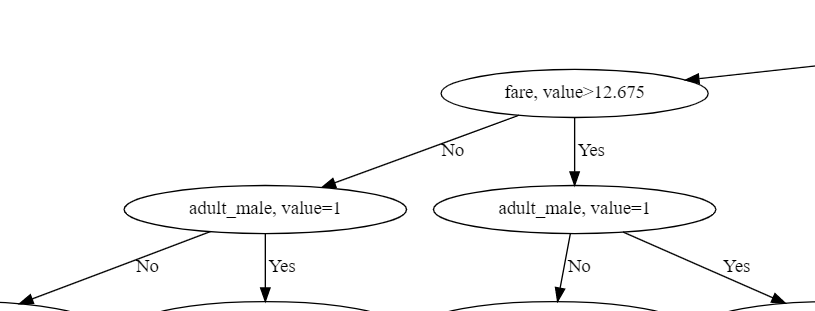  
  これにより、全てのデータに対して共通の処理ができるので、並列化との相性が良い。  
  例えば、入ってきたデータに対してadult_maleの層の判定と一つ上のfareの層の判定を並列に実行可能。
  <br></br>
* Ordered Boostingによる過学習の防止  
  XGBoostやLightGBMはあるデータ$x_i$での残差（勾配）を算出する際に、そのデータの目的変数$y_i$を学習したモデルの予測値を  
  使用して算出している。当然、$y_i$に近づきやすくなる(Leakageみたいな)ので、過学習気味になってしまう。これはXGBoost、LightGBMが抱える問題の一つ。  
  CatBoostはこれに対して、残差の計算に使うモデルと予測に使うモデルを分けることで対処している。  
  データ$x_i$の残差の計算には$x_{i-1}$までのデータを使って学習したモデルの予測値を使って残差を計算する。これにより、  
  $x_i$の目的変数$y_i$を学習データに含まないモデルから残差が計算されるため、過学習の防止につながる。  
  予測には通常通り、すべてのデータを使った予測値を足し合わせた結果を使う。  

## スタッキング（stacking）

下図のように複数レイヤーに分けて学習と予測をするアンサンブル手法。高精度が必要な場合やKaggle必須のテクニックである。  
それぞれのモデルにはGBDT、ランダムフォレストなどのアンサンブルのアルゴリズムを使うこともある。  
（アンサンブル済みのモデルをさらにアンサンブルするということ）  
下層のモデルは事前にハイパーパラメータを最適化しておくことが望ましい。  
実務ではチームメンバーそれぞれでモデルを最適化して最後にスタッキングするという分業も行われることがある。  

スタッキングの概要図(2階層の場合。3層以上もある)  
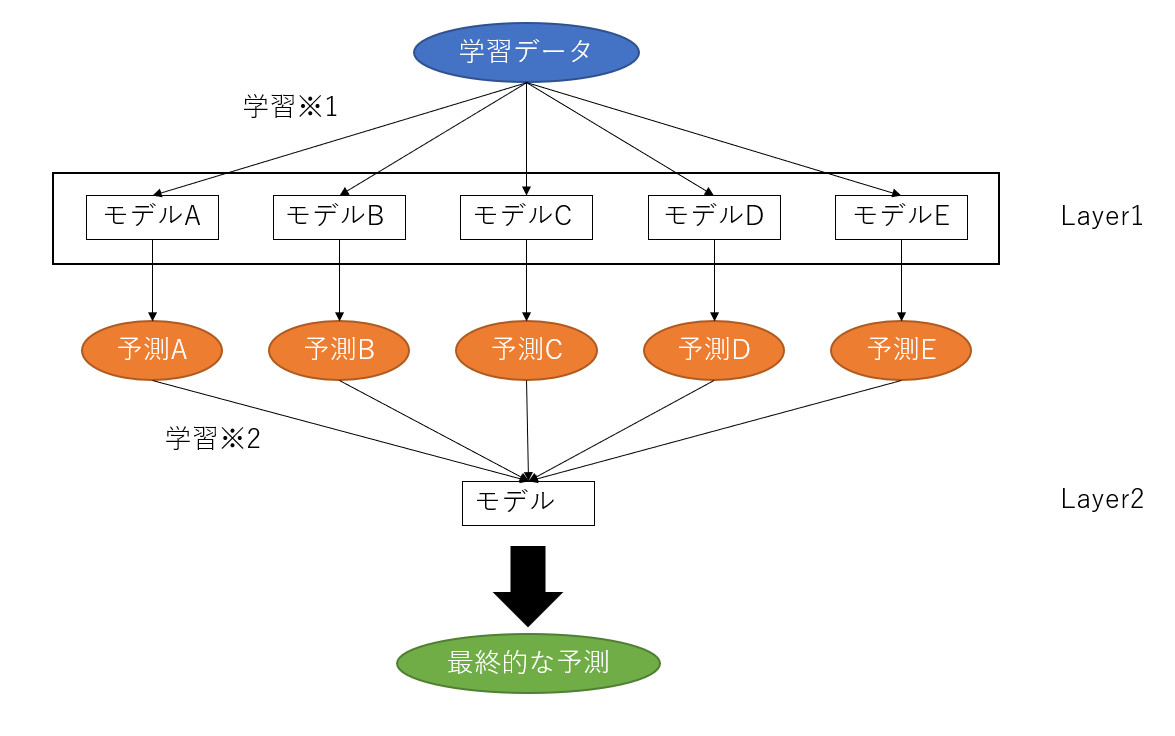

※1  
例えばモデルAでは学習データをk-fold CVして、ある1foldを未知データ、その他を学習データとしたときの予測 × k 通り学習した結果が予測Aになる。  
(なので、実際にはモデルAはk通り作られ、k通りの予測結果を集約して全データの予測値にしたものが予測A)  
このようにするのは、学習データを全てモデルAに学習させて学習データに対する予測値を出すと不正に精度が高くなってしまうため。  
未知のデータに対する精度が重要なので、学習時も仮想的な未知データを設定して予測値を出す。  

テストデータに対する各モデルによる予測には下記の２種類の方法がある。一つ目の方法が使われることが多い。    
・全学習データで再度学習してからテストデータに対する予測を行う方法  
・学習時におけるk通りのfoldの予測値の平均をテストデータに対する予測値とする方法  
テストデータに対する予測結果はLayer2で特徴量として予測に使用される。  

Layer1の各モデルは学習時にk通り、テストデータに対する予測で1通り作られることになる。  

※2  
ひとつ前のLayerの予測結果A～Eを特徴量としてモデルに学習させて最終的な予測結果を出す。  
この学習時に予測結果A～Eだけでなく元の特徴量を入れてもよい。